### Import potentials and coordinates from HDF5 file

In [1]:
import h5py
import numpy as np
import pandas as pd
from scipy.interpolate import RegularGridInterpolator as rgi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from numba import jit
import time
from interpolation.splines import LinearSpline, CubicSplines

In [2]:
#Potential field are stored in a HDF5 file
f=h5py.File('PA_v4.hdf5','r')

In [3]:
for name in f:
    print(name)

Coordinates
Potential Arrays
iselectrode


In [4]:
#coordinates x,y,z in unit of mm
x=f["Coordinates/X"].value/2.
y=f["Coordinates/Y"].value/2.
z=f["Coordinates/Z"].value/2.

### Set electrodes potentials and calculate spatial potential values
19 electrodes are set to certain potentials to create electric field to ionize Rydberg atoms

In [5]:
#set values of 19 electrodes, for ionization field of state n=30
#electrode_set_potentials=[187.*1.2,187.*1.2,-1.74,-278.*1.2,-0.114*1.2,-1900.,0.,3.97*1.2,-1.74*1.2,-278.*1.2,187.*1.2,187.*1.2,0.3*1.2,-278.*1.2,0.,0.,0.,0.318*1.2,0.307*1.2];
electrode_set_potentials=[195.,195.,-145.,-232.,-0.114,-1900.,0.,4.,0.3,-232.,195.,195.,-145.,-232.,0.,0.,0.,0.318,0.307];
electrode_set_potentials[9]=-250.
#electrode_set_potentials=[195.,195.,-150.,-545.,-0.114,-1900.,0.,4.,0.3,-545.,430.,430.,-150.,-545.,0.,0.,0.,0.318,0.307];

In [6]:
# generate potential by setting each electrode to its potential and adding up all electrodes' potential
potentials=np.zeros((len(x),len(y),len(z)))
for i in range(19):
    electroden=f["Potential Arrays/electrode"+str(i+1)].value
    potentials+=electrode_set_potentials[i]*electroden/10000.

### Interpolate potential arrays and plot cross sections for comparison

In [7]:
#generate potential interpolation

from scipy.interpolate import RegularGridInterpolator as rgi
p_interpolation=rgi((x,y,z),potentials)

In [9]:
minlimit = [min(x), min(y), min(z)]
maxlimit = [max(x), max(y), max(z)]
orders = [len(x), len(y), len(z)]
p_interpolation2 = LinearSpline(minlimit, maxlimit, orders, potentials)

Setting
[121 121 173]
(121, 121, 173)


In [10]:
p_interpolation(np.array([102.5,102.5,65.]))

array([ 3.48480343])

### Calculate single ion trajectory

Define velocity iteration function and trajectory iteration function for single ion.

MCP detector plane

In [11]:
phi=-82.*np.pi/180.
tmatrix=np.array([[np.cos(phi),0,-np.sin(phi)],
           [0,1,0],
           [np.sin(phi),0,np.cos(phi)]])

In [12]:
#center point of MCP plane
center=(tmatrix.dot(np.array([0.,0.,3.]))*2 + [247,205,214])/2
#c=(241+6*np.cos(phi) + np.tan(- phi)*(247 + 6*np.sin( - phi)))/2.
c=center[2] + np.tan(- phi)* center[0]
center, c

(array([ 126.47080421,  102.5       ,  107.4175193 ]), 1007.3040503174313)

In [134]:
#single ion's position and velocity iteration functions

@jit
def R(ri,vi,dt):                  #delta_t in unit of micro-second, displacement in unit of mm, v in unit of mm/us
    x_new=ri[0]+vi[0]*dt
    y_new=ri[1]+vi[1]*dt
    z_new=ri[2]+vi[2]*dt
    return np.array([x_new,y_new,z_new])

@jit
def Gradientforce(ri,vi,delta_t,dr):
    dvx=-100./(1.0364*87.) * (p_interpolation([ri[0]+dr,ri[1],ri[2]])[0]-p_interpolation([ri[0]-dr,ri[1],ri[2]])[0])/(dr*2) #- for positive ions, + for electrons
    dvy=-100./(1.0364*87.) * (p_interpolation([ri[0],ri[1]+dr,ri[2]])[0]-p_interpolation([ri[0],ri[1]-dr,ri[2]])[0])/(dr*2)
    dvz=-100./(1.0364*87.) * (p_interpolation([ri[0],ri[1],ri[2]+dr])[0]-p_interpolation([ri[0],ri[1],ri[2]-dr])[0])/(dr*2)
    vx_new=vi[0]+dvx * dt
    vy_new=vi[1]+dvy * dt
    vz_new=vi[2]+dvz * dt
    return np.array([vx_new,vy_new,vz_new])

def Gradientforce2(r,v,dt,dr):    
    dvx=-100./(1.0364*87.) * (p_interpolation([r[0]+dr,r[1],r[2]])-p_interpolation([r[0]-dr,r[1],r[2]]))/(dr*2) #- for positive ions, + for electrons
    dvy=-100./(1.0364*87.) * (p_interpolation([r[0],r[1]+dr,r[2]])-p_interpolation([r[0],r[1]-dr,r[2]]))/(dr*2)
    dvz=-100./(1.0364*87.) * (p_interpolation([r[0],r[1],r[2]+dr])-p_interpolation([r[0],r[1],r[2]-dr]))/(dr*2)
    vx_new=v[0]+dvx * dt
    vy_new=v[1]+dvy * dt
    vz_new=v[2]+dvz * dt
    return np.array([vx_new,vy_new,vz_new])

#@jit
def ion_exist(r):
    ion_number=len(r)
    ion_condition=[0 for i in range(ion_number)]
    for j in range(ion_number):
        r_ionj=r[j]
        ion_condition[j]=(r_ionj>[x[1],y[1],z[1]]).all() and (r_ionj<[x[-3],y[-3],z[-3]]).all() and (r_ionj[2]-np.tan(phi)*r_ionj[0]<=c)
        
    return ion_condition

"""
#Function to calculate two ions coulombic force
def VCoul(ra,rb):
    #coulombic acceleration of Rb ion at ra, due to repulsion of Rb ion at rb
    distance=np.linalg.norm(ra-rb)
    coulf=1.595 * 1.e-6 /distance**2
    return (ra-rb)*coulf/distance
"""
    
@jit
def VCoul(index,r_iter,ion_condition):
    r_origin=r_iter[index]
    ion_number=len(r_iter)
    force=np.zeros((1,3))
    for i in range(ion_number):
        if (i!=index and ion_condition[i]):
            distance=np.linalg.norm(r_origin - r_iter[i])
            coulf=1.595 * 1.e-6 / distance**2
            force += (r_origin - r_iter[i]) * coulf/distance
    return force[0]
    
    
@jit
def cross_ratio(r_n,r_iter,count,dt):
    x1=r_n[0]
    z1=r_n[2]
    x2=r_iter[0]
    z2=r_iter[2]
    a=np.array([[np.tan(-phi),1.],[(z2-z1)/(x1-x2),1]])
    b=np.array([c,(x1*z2-x2*z1)/(x1-x2)])
    
    r_p= np.linalg.solve(a,b)
    ratio=(r_p[0]-r_n[0])/(r_iter[0]-r_n[0])
    count += ratio
    y_p= r_n[1] +(r_iter[1]-r_n[1])*ratio
    t=count*dt
    r_new= np.array([np.sign(r_p[1]-center[2]) * np.sqrt((r_p[0]-center[0])**2 + (r_p[1]-center[2])**2),y_p-center[1],t])
    return r_new


In [135]:
@jit
def trajectory2(r_init,v_init,dt):
    r_iter=r_init
    v_iter=v_init 
    r_n=r_init
    count=0              #no appending?
    while (r_iter>[x[1],y[1],z[1]]).all() and (r_iter<[x[-2],y[-2],z[-2]]).all() and (r_iter[2]-np.tan(phi)*r_iter[0]<=c):
        # while loop condition: ion still in effective volume, and not hit the plane
        r_n=r_iter
        v_iter=Gradientforce(r_iter,v_iter,dt,dr)
        r_iter=R(r_iter,v_iter,dt)
        count+=1
        if count*dt>20:
            break
        
    x1=r_n[0]
    z1=r_n[2]
    x2=r_iter[0]
    z2=r_iter[2]
    a=np.array([[np.tan(-phi),1.],[(z2-z1)/(x1-x2),1]])
    b=np.array([c,(x1*z2-x2*z1)/(x1-x2)])
    
    r_p= np.linalg.solve(a,b)
    v=v_iter
    ratio=(r_iter[0]-r_p[0])/(r_iter[0]-r_n[0])
    count += ratio
    y_p= r_n[1] +(r_iter[1]-r_n[1])*ratio
    t=count*dt
    r_new= [np.sign(r_p[1]-center[2]) * np.sqrt((r_p[0]-center[0])**2 + (r_p[1]-center[2])**2),y_p-center[1],t]
    
    return [r_new,v]

Test ion_exist() and VCoul() functions

In [218]:
r_test=np.zeros((1000,3))
r0=np.array([94.5,102.5,54.5])
for i in range(len(r_test)):
    r_test[i]=r0 + [10*i, 0,0]
conditiontest=ion_exist(r_test)

**Distance step when calculating gradient has significant fluence on the trajectories**

In [137]:
dr=0.5       #dr[mm] is used when calculating gradients
dt=0.01     #dt[us]

In [221]:
def trajectories_ions(r_init,v_init,dt):
    ion_number=len(r_init)
    count=np.zeros(ion_number)
    r_iter=np.zeros((ion_number,3))
    r_n=np.zeros((ion_number,3))
    r_iter=r_init
    v_iter=v_init
    r_n=np.zeros((ion_number,3))
    
    #no appending?
    global condition
    condition = ion_exist(r_iter)
    sequence=[k for k in range(ion_number)]
    while any(condition):
        # while loop condition: ion still in effective volume, and not hit the plane
        """if iondistance<0.01:
            dt=0.0001
        else:
            dt=0.01"""
        t0=time.time()
        for i in sequence:
            if condition[i]:
                r_n[i]=np.array(r_iter[i])
                v_iter[i] = Gradientforce(r_iter[i],v_iter[i],dt,dr) + VCoul(i,r_iter,condition) * dt
                r_iter[i]=R(r_iter[i],v_iter[i],dt)
                count[i] += 1
            #print r_iter[0]
        if max(count * dt)>15:
            break
        t1=time.time()
        condition=ion_exist(r_iter)
        t2=time.time()
        print(r_iter[0])
        
    #map coordinates into detector plane coordinate
    r_final=np.zeros((ion_number,3))
    for k in range(ion_number):
        r_final[k]=cross_ratio(r_n[k],r_iter[k],count[k],dt)
    v_final=v_iter
    #print r_final
    #displacement=np.array(r_new1) - np.array(r_new2)
    ionsituation=np.concatenate((r_final,v_final),axis=1)
    print(r_final)
    return r_final

In [226]:
# 96.8  102.5   66.
#96.9,102.5,66.05
xc=np.linspace(96.9 - 0.05,96.9 + 0.05,11)
yc=np.linspace(102.5 - 0.01,102.5 + 0.01,5)
zc=np.linspace(66.05 - 0.01,66.05 + 0.01,5)
startpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
finalpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
v=np.zeros((len(xc)*len(yc)*len(zc),3))
ind=0
tstart=time.time()
for i in xc:
    for j in yc:
        for k in zc:
            startpoints[ind]=np.array([i,j,k])
            ind += 1

tend=time.time()
print(tend-tstart)
print(len(startpoints))

#startpoints

0.0
275


In [227]:
# generate potential by setting each electrode to its potential and adding up all electrodes' potential
electrode_set_potentials[9]=-350.
potentials=np.zeros((len(x),len(y),len(z)))
for i in range(19):
    electroden=f["Potential Arrays/electrode"+str(i+1)].value
    potentials+=electrode_set_potentials[i]*electroden/10000.
p_interpolation=rgi((x,y,z),potentials)

In [228]:
singlefinals=np.zeros((len(startpoints),3))
v0=np.array([0,0,0])
tstart1=time.time()
for i in range(len(startpoints)):
    [singlefinals[i],v[i]]=trajectory2(startpoints[i],v0,dt)

tend1=time.time()
print((tend1-tstart1)/60.)

LoweringError: Failed at object (object mode frontend)
Failed at object (object mode backend)
count.1
File "<ipython-input-135-50678e18b6bd>", line 7
[1] During: lowering "$221 = call $220(count.1, dt, r_iter, r_n, v_iter)" at <ipython-input-135-50678e18b6bd> (7)

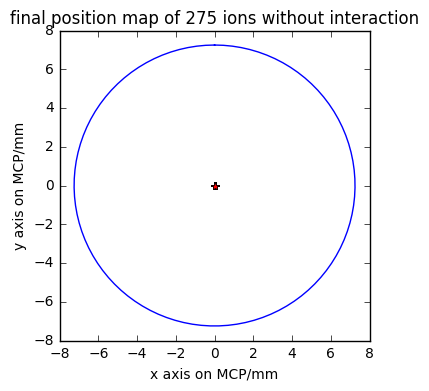

In [181]:
%matplotlib inline
plt.figure()
theta=np.linspace(0,2*np.pi,100)
plt.plot(7.25*np.sin(theta),7.25*np.cos(theta))
plt.axes().set_aspect('equal')
plt.plot(singlefinals[:,0],singlefinals[:,1],'r*')
plt.xlabel("x axis on MCP/mm")
plt.ylabel("y axis on MCP/mm")
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title("final position map of 275 ions without interaction")
plt.show()

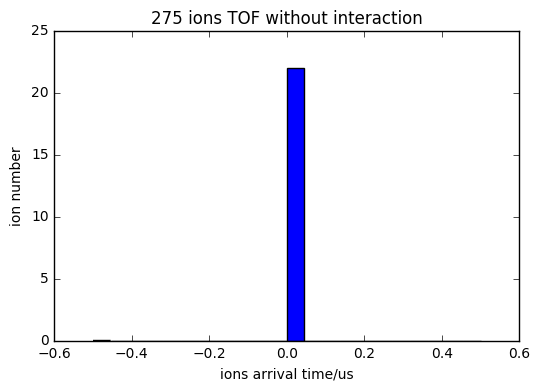

In [182]:
count, bins, ignored = plt.hist(singlefinals[:,2], 22, normed=True)
plt.xlabel("ions arrival time/us")
plt.ylabel("ion number")
plt.title("275 ions TOF without interaction")
plt.show()

In [229]:
ionfinalpoints=np.zeros((len(startpoints),3))
v=np.zeros((len(startpoints),3))

In [230]:
tstart2=time.time()
ionfinalpoints=trajectories_ions(startpoints,v,dt)
tend2=time.time()
print(tend2-tstart2)

[  96.85005869  102.48997515   66.04090928]
[  96.85017616  102.48992559   66.04272798]
[  96.85035263  102.48985156   66.04545638]
[  96.85058841  102.48975347   66.04909498]
[  96.85088396  102.48963189   66.05364452]
[  96.85123955  102.48948794   66.05910715]
[  96.85165778  102.48932235   66.06548441]
[  96.85213974  102.48913578   66.0727777 ]
[  96.8526863   102.48892889   66.08098817]
[  96.85329823  102.48870236   66.0901168 ]
[  96.8539763   102.48845683   66.10016445]
[  96.85472126  102.48819295   66.11113189]
[  96.85553387  102.4879114    66.12301983]
[  96.85641488  102.48761283   66.13582895]
[  96.85736502  102.48729789   66.14955984]
[  96.85838502  102.48696719   66.16421309]
[  96.85947557  102.48662134   66.1797892 ]
[  96.86063737  102.48626088   66.19628864]
[  96.86187111  102.48588635   66.21371186]
[  96.86317746  102.48549826   66.23205925]
[  96.86455711  102.48509708   66.25133122]
[  96.86601074  102.48468332   66.27152813]
[  96.867539    102.48425746   6

In [198]:
finalpoints_good=ionfinalpoints[np.linalg.norm(ionfinalpoints[:,:2],axis=1) < 7.25]
finalpoints_good

array([[  4.81391478,   5.09151407,  16.39726449],
       [  7.07445814,   0.99598504,  16.55119401],
       [  5.17609532,   0.34021703,  16.41132527],
       [  4.83758382,  -0.06195384,  16.38808817],
       [  5.71849418,  -3.6037691 ,  16.46518667],
       [  5.89736892,  -2.46154245,  16.46740734],
       [  4.50663659,  -0.83496806,  16.36737012]])

In [199]:
ionfinalpoints.shape, finalpoints_good.shape

((275, 3), (7, 3))

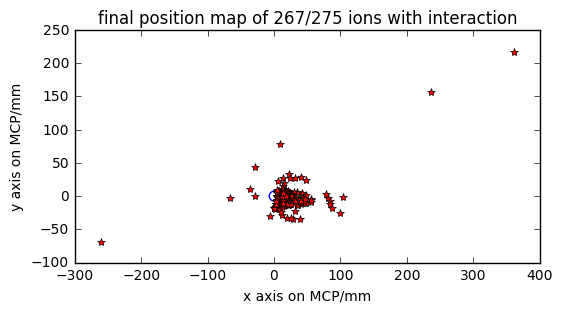

In [201]:
%matplotlib inline
plt.figure()
theta=np.linspace(0,2*np.pi,100)
plt.plot(7.25*np.sin(theta),7.25*np.cos(theta))
plt.axes().set_aspect('equal')
plt.plot(ionfinalpoints[:,0],ionfinalpoints[:,1],'r*')
plt.xlabel("x axis on MCP/mm")
plt.ylabel("y axis on MCP/mm")
#plt.xlim([-8,8])
#plt.ylim([-8,8])
plt.title("final position map of 267/275 ions with interaction")
plt.show()

In [28]:
"""
%matplotlib notebook
newplot=plt.figure()
ionplot=newplot.add_subplot(111,projection='3d')
#mp.plot(MCP[:,0],MCP[:,1],MCP[:,2],label='MCP')
ionplot.plot(startpoints[:,0],startpoints[:,1],startpoints[:,2],'.')
#mp.plot(points[:,0],points[:,1],points[:,2])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Start point, x:94.45 - 94.55, y:102.49 - 102.51, z:55.49 - 55.51 \n ion distance 5um")
plt.show()
"""

'\n%matplotlib notebook\nnewplot=plt.figure()\nionplot=newplot.add_subplot(111,projection=\'3d\')\n#mp.plot(MCP[:,0],MCP[:,1],MCP[:,2],label=\'MCP\')\nionplot.plot(startpoints[:,0],startpoints[:,1],startpoints[:,2],\'.\')\n#mp.plot(points[:,0],points[:,1],points[:,2])\nplt.xlabel("X")\nplt.ylabel("Y")\nplt.title("Start point, x:94.45 - 94.55, y:102.49 - 102.51, z:55.49 - 55.51 \n ion distance 5um")\nplt.show()\n'

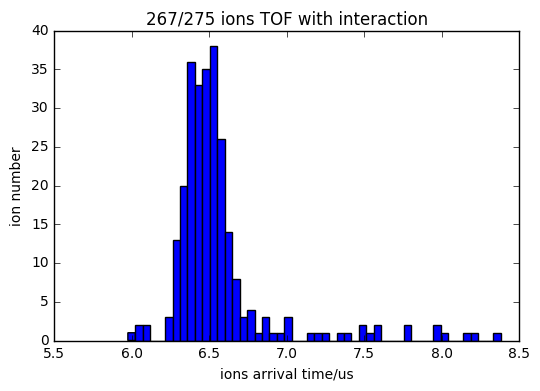

In [29]:
%matplotlib inline
count, bins, ignored = plt.hist(finalpoints_good[:,2], 50)
plt.xlabel("ions arrival time/us")
plt.ylabel("ion number")
plt.title("267/275 ions TOF with interaction")
plt.show()

Deflection Ring 2 voltage = -232V

In [30]:
electrode_set_potentials=[195.,195.,-145.,-232.,-0.114,-1900.,0.,4.,0.3,-232.,195.,195.,-145.,-232.,0.,0.,0.,0.318,0.307];

In [167]:
# 96.8  102.5   66.
#96.9,102.5,66.05
xc=np.linspace(96.9 - 0.05,96.9 + 0.05,11)
yc=np.linspace(102.5 - 0.01,102.5 + 0.01,5)
zc=np.linspace(66.05 - 0.01,66.05 + 0.01,5)
startpoints2=np.zeros((len(xc)*len(yc)*len(zc),3))
finalpoints2=np.zeros((len(xc)*len(yc)*len(zc),3))
v=np.zeros((len(xc)*len(yc)*len(zc),3))
ind=0
tstart=time.time()
for i in xc:
    for j in yc:
        for k in zc:
            startpoints2[ind]=np.array([i,j,k])
            ind += 1

tend=time.time()
print(tend-tstart)
print(len(startpoints2))

#startpoints

0.0009999275207519531
275


In [168]:
startpoints

array([[ 126.38346108,  101.58313139,  109.88586893],
       [ 126.45378902,  101.90689907,  110.08102797],
       [ 126.18229879,  103.06769044,  110.07523221],
       [ 126.19333988,  101.35596655,  109.87556232],
       [ 126.44458173,  102.05925494,  109.93774683],
       [ 126.15118112,  101.68648564,  109.81834438],
       [ 126.12052689,  102.14053751,  110.06606151],
       [ 126.39653082,  104.52306938,  110.24273552],
       [ 126.47264797,  101.75844305,  109.89174056],
       [ 126.31106228,  102.10273891,  109.99707167],
       [ 126.39310065,  102.53098067,  109.77705625],
       [ 126.31137154,  102.33905855,  110.07265315],
       [ 107.53715776,   86.22066643,   86.16451171],
       [ 126.39226865,  102.06012096,  109.87833333],
       [ 126.25371786,  102.23534473,  109.98113517],
       [ 126.66712788,  102.65930113,  109.85159388],
       [ 126.46755146,  102.54595435,  110.0645312 ],
       [ 126.43633432,  100.24990648,  110.09352684],
       [ 126.39632963,  103.

In [33]:
# generate potential by setting each electrode to its potential and adding up all electrodes' potential
potentials=np.zeros((len(x),len(y),len(z)))
for i in range(19):
    electroden=f["Potential Arrays/electrode"+str(i+1)].value
    potentials+=electrode_set_potentials[i]*electroden/10000.
p_interpolation=rgi((x,y,z),potentials)

In [34]:
ionfinalpoints2=np.zeros((len(startpoints2),3))
v=np.zeros((len(startpoints2),3))
tstart2=time.time()
ionfinalpoints2=trajectories_ions(startpoints2,v,dt)
tend2=time.time()
print(tend2-tstart2)

[[  2.93727741e+00  -9.65229331e-01   6.69792692e+00]
 [  3.16131761e+00  -6.19030737e-01   6.80148715e+00]
 [  3.15911161e+00   6.51535591e-01   6.80398884e+00]
 [  2.92447391e+00  -1.19986961e+00   6.62623298e+00]
 [  3.02077601e+00  -4.95497293e-01   6.72826183e+00]
 [  2.88387241e+00  -8.82372474e-01   6.72343045e+00]
 [  3.17061601e+00  -3.95714431e-01   6.81576203e+00]
 [  3.19289261e+00   3.35351884e+00   7.48054849e+00]
 [  2.90737022e+00  -8.48338377e-01   6.62140009e+00]
 [  3.07162681e+00  -4.03351688e-01   6.70601521e+00]
 [  2.77752848e+00   5.44017141e-02   6.76137281e+00]
 [  3.16374768e+00  -2.00657154e-01   6.82529125e+00]
 [  2.72312225e+00  -5.55406500e+00   8.12530961e+00]
 [  2.83891869e+00  -4.85960517e-01   6.63420535e+00]
 [  3.03664524e+00  -2.72813504e-01   6.69111274e+00]
 [  2.85807091e+00   1.55069770e-01   6.74116771e+00]
 [  3.14013609e+00   9.54497972e-03   6.82422771e+00]
 [  3.08667172e+00  -2.86946231e+00   6.90984937e+00]
 [  2.91607444e+00   5.49121

In [73]:
fions=h5py.File('TOF and final position with Coulombic interaction.hdf5','w')

In [76]:
TOFv2=fions.create_group("new voltage set")

In [78]:
finalcoulv2=TOFv2.create_dataset("final points",(ionfinalpoints.shape),dtype=np.float64)
finalcoulv2[...]=ionfinalpoints

In [79]:
startcoul=TOFv2.create_dataset("startpoints",(startpoints.shape),dtype=np.float64)
startcoul[...]=startpoints

In [237]:
fcoul=h5py.File('TOF and final position with Coulombic interaction.hdf5','w')

In [238]:
startcoul=fcoul.create_dataset("startpoints",(startpoints.shape),dtype=np.float64)

In [265]:
startcoul[...]=startpoints

In [239]:
finalcoul=fcoul.create_dataset("finalpoints",(finalpoints.shape),dtype=np.float64)
finalcoul[...]=finalpoints

In [27]:
fnocoul=h5py.File('TOF and final position without Couloumbic interaction.hdf5','w')

In [28]:
single=fnocoul.create_dataset("single ions final position",(singlefinals.shape),dtype=np.float64)

In [162]:
v0=np.zeros((100,3))
r0=np.zeros((100,3))
for k in range(len(r0)):
    r0[k]=[94.5 + k*0.1,102.5,54.5]
#r0=np.array([[94.5,102.5,54.5],[94.6,102.5,54.5],[94.7,102.5,54.5],[94.8,102.5,54.5]])
tstart=time.time()
r=trajectories_ions(r0,v0,dt)
tend=time.time()
print r,tend-tstart

[[ 0.18829336  0.07690852  4.45376038]
 [ 0.05391135  0.08748673  4.44320879]
 [-0.07262028  0.0979      4.43302534]
 [-0.19288363  0.10811478  4.42307097]
 [-0.30193144  0.11810359  4.41349445]
 [-0.3992394   0.12778341  4.40436299]
 [-0.48707629  0.13710076  4.39575847]
 [-0.56709355  0.14628521  4.38757263]
 [-0.6336089   0.15531062  4.37977038]
 [-0.68683687  0.16414294  4.37236991]
 [-0.719545    0.17271789  4.36547806]
 [-0.73730465  0.18100197  4.35924184]
 [-0.75769785  0.1892606   4.35392753]
 [-0.76707881  0.19739203  4.34897964]
 [-0.78482101  0.20536316  4.34435681]
 [-0.80398912  0.21300716  4.3395068 ]
 [-0.83763186  0.22029878  4.33458917]
 [-0.88079716  0.22740469  4.329504  ]
 [-0.93059264  0.23418254  4.32354854]
 [-0.99867372  0.24077771  4.31781273]
 [-1.07005457  0.24711208  4.31219076]
 [-1.15118889  0.25299205  4.30590794]
 [-1.23979883  0.25881449  4.30018954]
 [-1.32781134  0.2644488   4.29437629]
 [-1.42037083  0.26988538  4.28862454]
 [-1.50727853  0.27515801

### Coulomb interaction influence

In [79]:
#Starting point r0 and initial velocity v0
r0=np.array([94.5,102.5,55.5])
v0=np.array([0,0,0])
[f10,v10]=trajectory2(r0,v0,dt)
f10,v10

([0.27608091170657961, 0.069906204468793476, 4.4917916905373669],
 array([ 62.59098621,   0.063188  ,  12.78745611]))

In [228]:
xc=np.linspace(94.5 - 0.05,94.5 + 0.05,21)
yc=np.linspace(102.5 - 0.01,102.5 + 0.01,5)
zc=np.linspace(55.5 - 0.01,55.5 + 0.01,5)
print xc
print yc
print zc

[ 94.45   94.455  94.46   94.465  94.47   94.475  94.48   94.485  94.49
  94.495  94.5    94.505  94.51   94.515  94.52   94.525  94.53   94.535
  94.54   94.545  94.55 ]
[ 102.49   102.495  102.5    102.505  102.51 ]
[ 55.49   55.495  55.5    55.505  55.51 ]


In [40]:
r0=np.array([102.5,102.5,65.])
v0=np.array([0.,0.,0.])

In [35]:
%load_ext Cython

In [37]:
%%cython

cdef int a = 0
for i in range(10):
    a += i
print(a)

DistutilsPlatformError: Unable to find vcvarsall.bat

In [33]:
t0 = time.time()
r_iter = startpoints
v_iter = np.zeros((len(startpoints),3))
r_n = np.zeros((len(startpoints),3))
condition=ion_exist(startpoints)
count = np.zeros(len(startpoints))
r_n=startpoints
#v_iter[i] += VCoul(i,r_iter,condition) * dt
for i in range(275):
    
    if condition[i]:
        
        v_iter[i]=Gradientforce(np.array(r_iter[i]),np.array(v_iter[i]),dt,dr)
        r_iter[i]=R(r_iter[i],v_iter[i],dt)
        count[i] += 1
        #print r_iter[0]

condition=ion_exist(r_iter)

In [118]:
%timeit Gradientforce(np.array(r_iter[i]),np.array(v_iter[i]),dt,dr)

1000 loops, best of 3: 1.01 ms per loop


In [119]:
Gradientforce(np.array(r_iter[i]),np.array(v_iter[i]),dt,dr)

array([ 0.01534026,  0.00021232,  0.18502047])

In [117]:
%timeit Gradientforce2(np.array(r_iter[i]),np.array(v_iter[i]),dt,dr)

1000 loops, best of 3: 1.01 ms per loop


In [116]:
%timeit Gradientforce3(np.array(r_iter[i]),np.array(v_iter[i]),dt,dr)

10000 loops, best of 3: 51.4 µs per loop


In [120]:
Gradientforce3(np.array(r_iter[i]),np.array(v_iter[i]),dt,dr)

array([ 0.01534086,  0.00021237,  0.18502034])

In [151]:
%timeit condition = ion_exist(startpoints)

100 loops, best of 3: 2.58 ms per loop


In [148]:
%timeit Gradientforce(startpoints[10],np.zeros(3),dt,dr)

1000 loops, best of 3: 999 µs per loop


In [27]:
from scipy import spatial

In [35]:
A = np.random.random((10,2))*100

In [36]:
pt = [6,30]

In [37]:
A[spatial.KDTree(A).query(pt)[1]]

array([  2.88361217,  37.84305496])

In [43]:
from numba import guvectorize, float64, jit, uint32, int64

In [95]:
@jit(uint32(float64[:],float64))
def find_nearest(a, a0):
    idx = np.abs(a-a0).argmin()
    return idx

In [100]:
type(find_nearest(x,93.2))

int

In [82]:
%timeit find_nearest(np.array([93.2,92.4,65.2]))

The slowest run took 36.18 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 8.69 µs per loop


In [188]:
@jit
def p_interpolate(ri):
    idxx = find_nearest(x, ri[0])
    idxy = find_nearest(y, ri[1])
    idxz = find_nearest(z, ri[2])
    x0 = x[idxx]
    x1 = x[idxx+1]
    y0 = y[idxy]
    y1 = y[idxy+1]
    z0 = z[idxz]
    z1 = z[idxz+1]
    xd = (ri[0] - x0)/(x1 - x0)
    yd = (ri[1] - y0)/(y1 - y0)
    zd = (ri[2] - z0)/(z1 - z0)
    c00 = (1 - xd) * potentials[idxx,idxy,idxz] + xd * potentials[idxx+1,idxy,idxz]
    c01 = (1 - xd) * potentials[idxx,idxy,idxz+1] + xd * potentials[idxx+1,idxy,idxz+1]
    c10 = (1 - xd) * potentials[idxx,idxy+1,idxz] + xd * potentials[idxx+1,idxy+1,idxz]
    c11 = (1 - xd) * potentials[idxx,idxy+1,idxz+1] + xd * potentials[idxx+1,idxy+1,idxz+1]
    c0 = c00*(1-yd) + c10 * yd
    c1 = c01*(1-yd) + c11 * yd
    fp = c0*(1-zd) + c1*zd
    return fp

In [189]:
@jit
def Gradientforce3(ri,vi,delta_t,dr):
    dvx=-100./(1.0364*87.) * (p_interpolate([ri[0]+dr,ri[1],ri[2]])-p_interpolate([ri[0]-dr,ri[1],ri[2]]))/(dr*2) #- for positive ions, + for electrons
    dvy=-100./(1.0364*87.) * (p_interpolate([ri[0],ri[1]+dr,ri[2]])-p_interpolate([ri[0],ri[1]-dr,ri[2]]))/(dr*2)
    dvz=-100./(1.0364*87.) * (p_interpolate([ri[0],ri[1],ri[2]+dr])-p_interpolate([ri[0],ri[1],ri[2]-dr]))/(dr*2)
    vx_new=vi[0]+dvx * dt
    vy_new=vi[1]+dvy * dt
    vz_new=vi[2]+dvz * dt
    return np.array([vx_new,vy_new,vz_new])

In [114]:
Gradientforce3(np.array(r_iter[i]),np.array(v_iter[i]),dt,dr)

array([ 0.01534086,  0.00021237,  0.18502034])

In [169]:
forcex3 = [Gradientforce3(i, np.ones(3), dt, dr) for i in startpoints2]
forcex1 = [Gradientforce(j, np.ones(3), dt, dr) for j in startpoints2]

In [219]:
comparex = [np.abs(forcex3[i][0]-forcex1[i][0]) for i in range(len(forcex3))]

In [220]:
comparex

[1.8416960110290148e-06,
 1.8244840156445008e-06,
 1.8072720202599868e-06,
 1.7900600250975174e-06,
 1.7728480297130034e-06,
 1.8589048818018483e-06,
 1.8419018672499732e-06,
 1.8248988524760534e-06,
 1.8078958379241783e-06,
 1.7908928233723032e-06,
 1.8761137527967264e-06,
 1.859319718633401e-06,
 1.8425256849141647e-06,
 1.8257316507508392e-06,
 1.8089376170316029e-06,
 1.8760856090871414e-06,
 1.8592924273530542e-06,
 1.8424992453969224e-06,
 1.8257060634407907e-06,
 1.8089128819287481e-06,
 1.876057465599601e-06,
 1.8592651358506629e-06,
 1.8424728061017248e-06,
 1.8256804761307421e-06,
 1.8088881463818041e-06,
 1.716661714779022e-06,
 1.7005700234662413e-06,
 1.6844783323755053e-06,
 1.6683866410627246e-06,
 1.652294949749944e-06,
 1.7338506086428396e-06,
 1.717967547332222e-06,
 1.7020844857995598e-06,
 1.6862014242668977e-06,
 1.6703183629562801e-06,
 1.7510395025066572e-06,
 1.7353650707541135e-06,
 1.7196906392236144e-06,
 1.7040162074710707e-06,
 1.6883417759405717e-06,
 1.75

In [12]:
import inspect

In [14]:
inspect.isclass(rgi)

True

In [15]:
isinstance(p_interpolation, rgi)

True